## Ejercicio 6

Realizar un barrido de parámetros (learning rate, cantidad de neuronas en la capa oculta, comparación de ReLU con Sigmoide)


Ahora vamos a crear una funcion de barrido de hiperparametros en la que le vamos a crear cierto intervalo para los hiperparametros learning rate, cantidad de neuronas capa oculta y si el tipo de funcion de activacion que se aplica en la capa oculta es ReLU o Sigmoide.
Vamos ademas a realiza un tipo de barrido de hiperparametros "Grid Layout" y "Random Layout" 

In [25]:
#Importacion de librerias
import numpy as np
import matplotlib.pyplot as plt

In [26]:
def generaradorContinuo(cantidad_ejemplos):
    # Genero los valores de x1 y x2, las cuales son las variables independientes de la funcion que queremos aproximar
    x1 = np.random.uniform(0, 10, cantidad_ejemplos)
    x2 = np.random.uniform(0, 10, cantidad_ejemplos)
    x = np.c_[x1, x2]
    # Genero los valores de t, la cual es la variable dependiente de la funcion que queremos aproximar
    # En este caso vamos a usar una funcion de un paraboloide hiperbolico y un paraboloide eliptico (vamos a probar los 2, simplemente se cambia el signo)
    a=2
    b=2
    h=5
    k=5
    t = (((np.power(x1-h,2))/(np.power(a,2))) + (np.power(x2-k,2)/(np.power(b,2))))/2*0.5

    t = np.reshape(t, (cantidad_ejemplos,1)) #Para no obtener un error luego

    return x, t

### Codigo base con ciertas modificaciones

In [27]:


# Generador basado en ejemplo del curso CS231 de Stanford: 
# CS231n Convolutional Neural Networks for Visual Recognition
# (https://cs231n.github.io/neural-networks-case-study/)
def generar_datos_clasificacion(cantidad_ejemplos, cantidad_clases):
    FACTOR_ANGULO = 0.79
    AMPLITUD_ALEATORIEDAD = 0.1

    # Calculamos la cantidad de puntos por cada clase, asumiendo la misma cantidad para cada 
    # una (clases balanceadas)
    n = int(cantidad_ejemplos / cantidad_clases)

    # Entradas: 2 columnas (x1 y x2)
    x = np.zeros((cantidad_ejemplos, 2))
    
    # Salida deseada ("target"): 1 columna que contendra la clase correspondiente (codificada como un entero)
    t = np.zeros(cantidad_ejemplos, dtype="uint8")  # 1 columna: la clase correspondiente (t -> "target")
    
    randomgen = np.random.default_rng()

    # Por cada clase (que va de 0 a cantidad_clases)...
    for clase in range(cantidad_clases):
        # Tomando la ecuacion parametrica del circulo (x = r * cos(t), y = r * sin(t)), generamos 
        # radios distribuidos uniformemente entre 0 y 1 para la clase actual, y agregamos un poco de
        # aleatoriedad
        radios = np.linspace(0, 1, n) + AMPLITUD_ALEATORIEDAD * randomgen.standard_normal(size=n)

        # ... y angulos distribuidos tambien uniformemente, con un desfasaje por cada clase
        angulos = np.linspace(clase * np.pi * FACTOR_ANGULO, (clase + 1) * np.pi * FACTOR_ANGULO, n)

        # Generamos un rango con los subindices de cada punto de esta clase. Este rango se va
        # desplazando para cada clase: para la primera clase los indices estan en [0, n-1], para
        # la segunda clase estan en [n, (2 * n) - 1], etc.
        indices = range(clase * n, (clase + 1) * n)

        # Generamos las "entradas", los valores de las variables independientes. Las variables:
        # radios, angulos e indices tienen n elementos cada una, por lo que le estamos agregando
        # tambien n elementos a la variable x (que incorpora ambas entradas, x1 y x2)
        x1 = radios * np.sin(angulos)
        x2 = radios * np.cos(angulos)
        x[indices] = np.c_[x1, x2] #Esta función une al vector x1 y a x2. Es como que genera una matriz.

        # Guardamos el valor de la clase que le vamos a asociar a las entradas x1 y x2 que acabamos
        # de generar
        t[indices] = clase

    return x, t


def inicializar_pesos(n_entrada, n_capa_2, n_capa_3):
    randomgen = np.random.default_rng()

    #w son los pesos, b son los sesgos. En este caso tenemos 2 capas luego de la capa de entrada
    
    #Se inicializan con un valor bajo. Por eso se multiplilcan por 0.1
    w1 = 0.1 * randomgen.standard_normal((n_entrada, n_capa_2))
    b1 = 0.1 * randomgen.standard_normal((1, n_capa_2))

    w2 = 0.1 * randomgen.standard_normal((n_capa_2, n_capa_3))
    b2 = 0.1 * randomgen.standard_normal((1,n_capa_3))

    return {"w1": w1, "b1": b1, "w2": w2, "b2": b2}


def ejecutar_adelante(x, pesos,valorTipoFuncionActivacion):
    # Funcion de entrada (a.k.a. "regla de propagacion") para la primera capa oculta
    z = x.dot(pesos["w1"]) + pesos["b1"]
    #Por más que b1 sea un vector y la multiplicación de x*w sea una matriz, como tienen la misma cantidad de columnas, se puede hacer la suma porque numpy intuye que queremos sumar a cada fila de la matriz el mismo vector b.

    if valorTipoFuncionActivacion == "relu":
        # Funcion de activacion ReLU para la capa oculta (h -> "hidden")
        h = np.maximum(0, z)
        #Esta función de activación convierte a 0 los valores negativos, y deja como está a los valores positivos.
    elif valorTipoFuncionActivacion == "sigmoide":
        h = 1 / (1 + np.exp(-z))

    # Salida de la red (funcion de activacion lineal). Esto incluye la salida de todas
    # las neuronas y para todos los ejemplos proporcionados
    y = h.dot(pesos["w2"]) + pesos["b2"]

    return {"z": z, "h": h, "y": y}



### Creación de función para medir la precisión

En el caso de regresion no podemos usar el error rate (cantidad de errores/cantidad de ejemplos ) o success rate (cantidad de clasificaciones correctas/cantidad de ejemplos), la cual usabamos en clasificacion, para calcular la medida de precision, por lo que tendremos que modificar nuestra funcion de calculaPrecision.


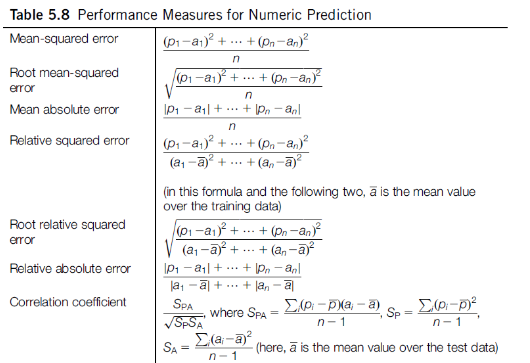

Esta vez no vamos a calcular la precision si no el error que se genera.
Tenemos varias opciones para el calculo del error, nosotros utilizamos la mean squared error (la primera) y la calculamos mediante la libreria de sklearn

In [28]:
from sklearn.metrics import mean_squared_error

def calculaError(conjuntoEjemplos,target,pesos,valorTipoFuncionActivacion):

    #Dado que aca no estamos clasificando, ya no usamos la funcion clasificar, que basicamente ejecutaba la ejecucion
    #hacia adelante y elegia el max valor. Aca simplemente ejecutamos la red hacia adelante con los ejemplos y pesos
    resultadosClasificacion = ejecutar_adelante(conjuntoEjemplos,pesos,valorTipoFuncionActivacion)
    #Calculamos error
    error=mean_squared_error(target,resultadosClasificacion["y"])
    return error
     

### Creacion de funcion de Early Stop o Parada Temprana

In [29]:
def earlyStop (xValidacion, tValidacion, pesos, vectorPrecision, ultimoEpoch,valorTipoFuncionActivacion):

    #Llamamos a la funcion para evaluar la precision con el conjunto de validacion y metemos esta precision al vector de precisiones
    precision = calculaError(xValidacion,tValidacion,pesos,valorTipoFuncionActivacion)
    vectorPrecision.append(precision)

    #Evaluamos este ultimo valor de precision con el anterior, si es menor, retornamos True, si no, retornamos False
    #Establecemos un valor de tolerancia para que no se detenga el entrenamiento por una diferencia minima (oscilaciones)
    TOLERANCIA = 20 #Esto quiere decir que tienen que haber pasado 20*N epochs para que se detenga el entrenamiento
    if len(vectorPrecision)>TOLERANCIA:
        if vectorPrecision[-1]>vectorPrecision[-2]:
            print("Se detuvo el entrenamiento en el epoch: ",ultimoEpoch)
            return True
        else:
            return False

### Funcion de train

Separamos la funcion de train del resto del codigo base para poder declarar la funcion de earlyStop antes

In [30]:
# x: n entradas para cada uno de los m ejemplos(nxm)
# t: salida correcta (target) para cada uno de los m ejemplos (m x 1)
# pesos: pesos (W y b)
def train(x, t, pesos, learning_rate, epochs, xValidacion, tValidacion, validationEpoch,valorTipoFuncionActivacion):
    
    # Cantidad de filas --> Esta es la cantidad de ejemplos
    m = np.size(x, 0)

    #Definimos el vector de precision
    vectorPrecision=[] 
    
    for i in range(epochs):
        # Ejecucion de la red hacia adelante
        resultados_feed_forward = ejecutar_adelante(x, pesos,valorTipoFuncionActivacion)
        y = resultados_feed_forward["y"]
        h = resultados_feed_forward["h"]
        z = resultados_feed_forward["z"]

        # Funcion de perdida (LOSS)
        #Ahora vamos a trabar con la funcion de Loss MSE (es mejor para regresion) y no con Softmax (mejor para clasificacion)
        loss=np.sum((t - y)**2)/m #Loss prom
        

        # Mostramos solo cada 1000 epochs
        if i %1000 == 0:
            print("Loss epoch", i, ":", loss)


        # Extraemos los pesos a variables locales
        w1 = pesos["w1"]
        b1 = pesos["b1"]
        w2 = pesos["w2"]
        b2 = pesos["b2"]

        # Ajustamos los pesos: Backpropagation
        #Modificamos la derivadas para usar MSE y no Softmax

        dL_dy = (2/m)*(y - t)  #Derivando L respecto de y obtenemos esta formula. Ojo aca el signo (regla cadena)            
        

        dL_dw2 = h.T.dot(dL_dy)                         # Ajuste para w2
        dL_db2 = np.sum(dL_dy, axis=0, keepdims=True)   # Ajuste para b2

        dL_dh = dL_dy.dot(w2.T)
        
        dL_dz = dL_dh       # El calculo dL/dz = dL/dh * dh/dz. La funcion "h" es la funcion de activacion de la capa oculta,
        dL_dz[z <= 0] = 0   # para la que usamos ReLU. La derivada de la funcion ReLU: 1(z > 0) (0 en otro caso)

        dL_dw1 = x.T.dot(dL_dz)                         # Ajuste para w1
        dL_db1 = np.sum(dL_dz, axis=0, keepdims=True)   # Ajuste para b1

        # Aplicamos el ajuste a los pesos
        w1 += -learning_rate * dL_dw1
        b1 += -learning_rate * dL_db1
        w2 += -learning_rate * dL_dw2
        b2 += -learning_rate * dL_db2

        # Actualizamos la estructura de pesos
        # Extraemos los pesos a variables locales
        pesos["w1"] = w1
        pesos["b1"] = b1
        pesos["w2"] = w2
        pesos["b2"] = b2

        #Evaluamos si nos encontramos en el epoch de validacion
        if i % validationEpoch == 0:
            #Llamamos a la funcion de parada temprana, la cual nos entrega un booleano
            #Le pasamos el conjunto de validacion, target de validacion, pesos, vector de prescion y numero actual de epoch (i)
            flagEarlyStop = earlyStop(xValidacion, tValidacion, pesos, vectorPrecision,i,valorTipoFuncionActivacion)
        
        #Si el flag de parada temprana es True, paramos el entrenamiento, si no seguimos con el bucle for normalmente
        if flagEarlyStop:
            break
    
    #Entregamos los nuevos pesos
    nuevosPesos = pesos
    return nuevosPesos

### Funcion Iniciar

Movemos la funcion iniciar aqui, de esta manera podemos ejecutar la funcion que acabamos de crear sin problema

In [31]:
def iniciar(xTrain, tTrain, xValidacion, tValidacion, valorLearningRate, valorNeuronaCapaOculta, valorTipoFuncionActivacion, valorCdadEpochs):
    
    # Inicializa pesos de la red
    NEURONAS_CAPA_OCULTA = int(valorNeuronaCapaOculta)
    NEURONAS_ENTRADA = 2 #Son 2 porque tenemos una por cada coordenada. Este valor no se cambia
    NEURONAS_SALIDA = 1 #Es 1 porque tenemos solo el valor de t=f(x1,x2). Este valor no se cambia
    pesos = inicializar_pesos(n_entrada=NEURONAS_ENTRADA, n_capa_2=NEURONAS_CAPA_OCULTA, n_capa_3=NEURONAS_SALIDA)

    # Entrenamos a la red. Le pasamos los conjuntos de train y validacion (para parada temprana)
    LEARNING_RATE=valorLearningRate
    EPOCHS=valorCdadEpochs
    VALIDATION_EPOCH=int(valorCdadEpochs/100) #Cada cuantas epochs hacemos el cross validation con el conjunto de validacion para la early stop
    nuevosPesos=train(xTrain, tTrain, pesos, LEARNING_RATE, EPOCHS, xValidacion, tValidacion, VALIDATION_EPOCH,valorTipoFuncionActivacion)

    #Calculamos precision de la red para el conjunto train y para el conjunto test
    errorValidacion=calculaError(xValidacion, tValidacion, nuevosPesos,valorTipoFuncionActivacion)
    print("El Mean squared error en conjunto de Test: "+str(errorValidacion)+"%")
    return errorValidacion

### Funcion de barrido de hiperparametros

In [32]:
from sklearn.model_selection import train_test_split #para separar train de validacion
def barrerHiperparametros(numero_ejemplos,graficar_datos,diccParametros,tipoBarrido):
    
    #Dado que estamos haciendo un barrido de hiperparametros, vamos a crear 1 conjunto y partirlo en 2 partes
    #El conjunto de train y el conjunto de validacion

    #Generacion de conjunto
    # Generamos datos del conjunto train
    x, t = generaradorContinuo(numero_ejemplos)

    #Separacion de conjunto
    #Separo train de validacion. La validación es el 10% del original. Train es el otro 90%.
    xTrain, xValidacion, tTrain, tValidacion = train_test_split(x, t, test_size=0.1)
    #El conjunto que creamos sera siempre el mismo para cada iteracion del barrido, para que la aleatoriedad no afecte al proceso

    #Graficamos
    # Graficamos los datos si es necesario
    if graficar_datos:
        # Parametro: "c": color (un color distinto para cada clase en t)
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x[:, 0], x[:, 1], t, c=t, cmap='seismic', linewidth=0.5)
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel('t')
        ax.set_title('Datos de entrenamiento')
        plt.show()
    

    #Hacemos una implementacion que evalue todas las combinaciones posibles de 3 listas distintas
    #La primera lista es la de los learning rate, la segunda es la de las neuronas capa oculta y la tercera es la del tipo de f de activacion
    #El primer vector tendra longitud n, el segundo longitud m y el ultimo longitud 2
    

    #Inicializamos los vectores de precision, pesos y errores
    vectorErrores=[]

    if tipoBarrido=="matricial":
        vectorLearningRate=diccParametros["learningRate"]
        vectorNeuronasCapaOculta=diccParametros["neuronasCapaOculta"]
        vectorCdadEpochs=diccParametros["cdadEpochs"]
    elif tipoBarrido=="random":
        paso1=0.05
        vectorLearningRate=np.random.uniform(0.05, 0.30, size=(int(3/paso1)))
        paso2=100
        vectorNeuronasCapaOculta=np.random.randint(100, 600, size=(int(600/paso2)))
        paso3=1000
        vectorCdadEpochs=np.random.randint(1000, 10000, size=(int(10000/paso3)))

    vectorTipoFuncionActivacion=diccParametros["tipoFuncionActivacion"] #Este vector es fijo, no se modifica

    valorLearningRateOptimo=0
    valorNeuronaCapaOcultaOptimo=0
    valorTipoFuncionActivacionOptimo=None
    valorCdadEpochsOptimo=0
    #Bucle for que recorre los 3 vectores
    for valorLearningRate in vectorLearningRate:
        for valorNeuronaCapaOculta in vectorNeuronasCapaOculta:
            for valorTipoFuncionActivacion in vectorTipoFuncionActivacion:
                for valorCdadEpochs in vectorCdadEpochs:
                    error=iniciar(xTrain, tTrain, xValidacion, tValidacion, valorLearningRate, valorNeuronaCapaOculta, valorTipoFuncionActivacion, valorCdadEpochs)
                    vectorErrores.append(error)
                    #Chequeamos si hubo alguna mejora en el error (error mas pequeño) y reemplazamos
                    if error < min(vectorErrores) and vectorErrores is not None:
                        valorLearningRateOptimo=valorLearningRate
                        valorNeuronaCapaOcultaOptimo=valorNeuronaCapaOculta
                        valorTipoFuncionActivacionOptimo=valorTipoFuncionActivacion
                        valorCdadEpochsOptimo=valorCdadEpochs
    #Imprimimos los valores optimos
    print("El valor optimo de learning rate es: "+str(valorLearningRateOptimo))
    print("El valor optimo de neuronas capa oculta es: "+str(valorNeuronaCapaOcultaOptimo))
    print("El valor optimo de tipo de funcion de activacion es: "+str(valorTipoFuncionActivacionOptimo))
    print("El valor optimo de cantidad de epochs es: "+str(valorCdadEpochsOptimo))

                
    

### Main

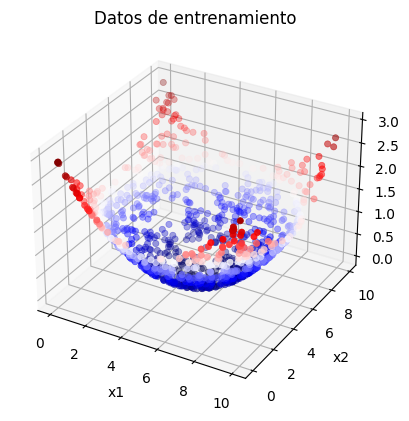

Loss epoch 0 : 1.6959046845028438
Se detuvo el entrenamiento en el epoch:  759
El Mean squared error en conjunto de Test: 0.07767346707472156%
Loss epoch 0 : 1.4394380612586892
Loss epoch 1000 : 0.06702939523941275
Se detuvo el entrenamiento en el epoch:  1820
El Mean squared error en conjunto de Test: 0.07061336695353194%
Loss epoch 0 : 2.7238747342460776
Loss epoch 1000 : 0.09438772204985033
Loss epoch 2000 : 0.0828391218609867
Se detuvo el entrenamiento en el epoch:  2356
El Mean squared error en conjunto de Test: 0.06129146897878754%
Loss epoch 0 : 1.4367582597121904
Se detuvo el entrenamiento en el epoch:  680
El Mean squared error en conjunto de Test: 0.09975488651719604%
Loss epoch 0 : 1.9391126380932397
Se detuvo el entrenamiento en el epoch:  525
El Mean squared error en conjunto de Test: 0.12037414366371105%
Loss epoch 0 : 2.2214500470827185
Se detuvo el entrenamiento en el epoch:  820
El Mean squared error en conjunto de Test: 0.09253505138915213%
Loss epoch 0 : 2.9357875870

/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipyke

Se detuvo el entrenamiento en el epoch:  660
El Mean squared error en conjunto de Test: 2.711025361208678e+53%
Loss epoch 0 : 0.47473651472795786


/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))


Loss epoch 1000 : 2.211073927361673e+116
Se detuvo el entrenamiento en el epoch:  1820
El Mean squared error en conjunto de Test: 3.655897367750064e+208%
Loss epoch 0 : 0.9557335312116831


/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipyke

Loss epoch 1000 : 0.6416203683578068


/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipyke

Loss epoch 2000 : 0.3941331123277019


/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipyke

Loss epoch 3000 : 0.25681737693923384


/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipyke

Loss epoch 4000 : 0.17461766003074122


/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipyke

Loss epoch 5000 : 0.12391288741365852


/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipyke

Loss epoch 6000 : 0.09207190053717584


/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipyke

Loss epoch 7000 : 0.07172104737929759


/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))


El Mean squared error en conjunto de Test: 0.0494340359616718%
Loss epoch 0 : 6.665793916606373
Se detuvo el entrenamiento en el epoch:  680
El Mean squared error en conjunto de Test: 9.238898002406503e+112%
Loss epoch 0 : 3.1046927442987977


/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipyke

Se detuvo el entrenamiento en el epoch:  300
El Mean squared error en conjunto de Test: 613310665936870.9%
Loss epoch 0 : 3.9026216031660907


/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipyke

Se detuvo el entrenamiento en el epoch:  820
El Mean squared error en conjunto de Test: 1.2793912532309696e+84%
Loss epoch 0 : 0.40040838689235986


/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipyke

Loss epoch 1000 : 130.40968258203745


/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipyke

Loss epoch 2000 : 0.8770807905106992


/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipyke

Loss epoch 3000 : 0.3117935785616756


/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipyke

Loss epoch 4000 : 0.22490461209594884


/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipyke

Loss epoch 5000 : 0.16522164429038178


/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipyke

Loss epoch 6000 : 0.12322165127969308


/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipyke

Loss epoch 7000 : 0.09352416779795733


/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipyke

Loss epoch 8000 : 0.07243373863849337


/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipyke

Loss epoch 9000 : 0.057385494923020815


/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))


El Mean squared error en conjunto de Test: 0.039907799818265366%
Loss epoch 0 : 5.4445726632857925
Se detuvo el entrenamiento en el epoch:  240
El Mean squared error en conjunto de Test: 2.771815373270698e+17%
Loss epoch 0 : 0.5615896382452236
Loss epoch 1000 : 0.5955419438392803
Loss epoch 2000 : 0.25490334972021816
Loss epoch 3000 : 0.1507860284712774
Loss epoch 4000 : 0.11055779939614725
Loss epoch 5000 : 0.09071893839222621
Loss epoch 6000 : 0.07887028025020176
Loss epoch 7000 : 0.07081312508811465
Loss epoch 8000 : 0.06483627261755628
Loss epoch 9000 : 0.06012840740259232
El Mean squared error en conjunto de Test: 0.04952752807996208%
Loss epoch 0 : 0.5323850016446681
Loss epoch 1000 : 0.6124820445045718
Loss epoch 2000 : 0.292064998622695
Loss epoch 3000 : 0.17302271999262805
Loss epoch 4000 : 0.12179879955115629
Loss epoch 5000 : 0.09615790176777671
Loss epoch 6000 : 0.08151354387305987
Loss epoch 7000 : 0.07224009643072557
El Mean squared error en conjunto de Test: 0.0584255566

/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipyke

Se detuvo el entrenamiento en el epoch:  660
El Mean squared error en conjunto de Test: 4.495187052331094e+16%
Loss epoch 0 : 1.0345376296761335


/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipyke

Loss epoch 1000 : 4.74813740083548e+112


/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))


Se detuvo el entrenamiento en el epoch:  1820
El Mean squared error en conjunto de Test: 2.6792952947521217e+201%
Loss epoch 0 : 1.7751676758780695


/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipyke

Loss epoch 1000 : inf


/home/juani/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/3193481419.py:21: RuntimeWarning: overflow encountered in square
  loss=np.sum((t - y)**2)/m #Loss prom
/home/juani/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/tmp/ipykernel_32284/1018210144.py:74: RuntimeWarning: overflow encountered in exp
  h = 1 / (1 + np.exp(-z))
/tmp/ipykernel_32284/3193481419.py:21: RuntimeWarning: overflow encountered in square
  loss=np.sum((t - y)**2)/m #Loss prom
/home/juani/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: 

ValueError: Input contains NaN.

In [33]:
#Estas serán los parámetros a analizar. Las listas tienen el siguiente orden:
#(valor_min, valor_max, paso)
paso1=0.05
rango_learning_rate=np.linspace(0.05, 0.30, int(3/paso1))
paso2=100
rango_cant_neuronas=np.linspace(100, 600,int(600/paso2))
funciones_activacion = ('relu', 'sigmoide')
paso3=1000
rango_epochs=np.random.randint(1000, 10000,int(10000/paso3))

#para pasarlos facil a la función los meto en un diccionario.
diccParametros={"learningRate": rango_learning_rate,
                 "neuronasCapaOculta": rango_cant_neuronas,
                 "tipoFuncionActivacion": funciones_activacion,
                 "cdadEpochs": rango_epochs}


#Ejecutamos la funcion
barrerHiperparametros(1000,graficar_datos=True,diccParametros=diccParametros,tipoBarrido="matricial")